## Covid Data Analysis - South Korea

In this exploratory analysis we focus on the following questions:
1. How prevalent was covid in South Korea, and how did it develop in the first six months of 2020?    
2. Were there any population groups and/or geographical regions that were much more or much less affected than others?
3. Are there specific group events that can explain trends, and which part of the infections can be explained by those types of events?
4. By comparing policy implementation timelines with COVID case and death development over time, can we find out what the triggers were for implementing new or lowering the amount of policy measures?
5. Which types of policy measures did the Korean government take, and at how long did they stay in place?

This Notebook is organised into 4 main sections:

* Data Preparation
* Exploratory Analysis
* Summary of findings
* Limitations & suggestions for further research


### Part 1: Data Pre-processing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Disable scientific notification in the entire notebook
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
sns.set_style('white')
sns.set_palette("ch:.25")

In [ ]:
path = "/content/drive/MyDrive/Csv's for colab/Covid Data/"

cases = pd.read_csv(path+'Case.csv')           # group infections
patient = pd.read_csv(path+'PatientInfo.csv')   # individual patients
time = pd.read_csv(path+'Time.csv')            # prevalence/incidence over time
timeage = pd.read_csv(path+'TimeAge.csv')      # covid case development by age group
timegender = pd.read_csv(path+'TimeGender.csv')# covid case development by gender
timeprovince = pd.read_csv(path+'TimeProvince.csv')# covid cases development by province
region = pd.read_csv(path+'Region.csv')        # regions/administrative structure
floating = pd.read_csv(path+'SeoulFloating.csv')# population movements
policy = pd.read_csv(path+'Policy.csv')         # covid policies over time

#### Patient data

In [ ]:
patient.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [ ]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


We can see there are is a lot of missing information, only 4 features are having no missings. Thus, analysing gender, age, infection case and number of contacts would be questionable since we cannot know whether the cases for which this data was included are representative. Analysing by province should work however.


In [ ]:
patient["confirmed_date"] = pd.to_datetime(patient["confirmed_date"])
earliest_case = patient["confirmed_date"].min()
last_case = patient["confirmed_date"].max()

print('earliest dates: ' + str(earliest_case))
print('latest dates: ' + str(last_case))

earliest dates: 2020-01-20 00:00:00
latest dates: 2020-06-30 00:00:00


In [ ]:
patient.nunique()

patient_id            5164
sex                      2
age                     11
country                 16
province                17
city                   163
infection_case          51
infected_by            606
contact_number          88
symptom_onset_date     129
confirmed_date         148
released_date          130
deceased_date           39
state                    3
dtype: int64

Looking at the amount of unique values per feature, a few things are catching attention:
* As the patient_id is unique, this means each row is representing one person. This makes that in the entire timeframe of the dataset there have been 5164 hospitalised covid cases, of which 66 died.   
* The dataset is said to contain covid cases in South Korea, however the country column consists of 16 different values for country.
* The amount of distinct values for province does match the amount of provinces in Korea, thus we want to doublecheck before analysing by province.

In [ ]:
patient["country"].unique()

array(['Korea', 'China', 'United States', 'France', 'Thailand', 'Canada',
       'India', 'Switzerland', 'Germany', 'Indonesia', 'Vietnam',
       'Foreign', 'Mongolia', 'United Kingdom', 'Spain', 'Bangladesh'],
      dtype=object)

In [ ]:
patient = patient.rename(columns={"country":"nationality"})
patients_nationality = patient.groupby(["nationality"])[["patient_id"]].count()
patients_nationality.sort_values("patient_id", ascending=False).head(10)

,patient_id
nationality,
Korea,5123
China,11
Foreign,7
United States,6
Bangladesh,5
Indonesia,2
Thailand,2
Canada,1
France,1


We will assume country stands for nationality, as the province for all cases was in South Korea. The far majority of cases is however Korean.

In [ ]:
patient.groupby("state")[["patient_id"]].count()

,patient_id
state,
deceased,78
isolated,2158
released,2929


In [ ]:
patient["province"].unique()

array(['Seoul', 'Busan', 'Daegu', 'Gwangju', 'Incheon', 'Daejeon',
       'Gyeonggi-do', 'Sejong', 'Ulsan', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do'],
      dtype=object)

#### Region Data

First we try to get an idea of the administrative structure of Korea.

We can distinguish 2 levels of administrative regions in South Korea:

Upper Level (17 Provincial-level divisions)
* Special City: Seoul
* Metropolitan Cities: Busan / Daegu / Daejeon / Gwangju / Incheon / Ulsan
* Metropolitan Autonomous City: Sejong
* Provinces(-do): Gyeonggi-do / Gangwon-do / Chungcheongbuk-do / Chungcheongnam-do / Jeollabuk-do / Jeollanam-do / Gyeongsangbuk-do / Gyeongsangnam-do
* Self-governing province: Jeju-do

Lower Level (Municipal-level divisions)
* City(-si) List of cities in South Korea
* County(-gun) List of counties of South Korea
* District(-gu) List of districts in South Korea

https://en.wikipedia.org/wiki/Administrative_divisions_of_South_Korea

In [ ]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   code                      244 non-null    int64  
 1   province                  244 non-null    object 
 2   city                      244 non-null    object 
 3   latitude                  244 non-null    float64
 4   longitude                 244 non-null    float64
 5   elementary_school_count   244 non-null    int64  
 6   kindergarten_count        244 non-null    int64  
 7   university_count          244 non-null    int64  
 8   academy_ratio             244 non-null    float64
 9   elderly_population_ratio  244 non-null    float64
 10  elderly_alone_ratio       244 non-null    float64
 11  nursing_home_count        244 non-null    int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 23.0+ KB


In [ ]:
region[["code", "city", "province"]].nunique()

code        244
city        222
province     18
dtype: int64

When printing out the columns of our dataset, we notice there are 2 columns that indicate regions: province and city, while the 'code' variable can serve as a unique case identifier.
* Since 'city' has less unique values than 'code' there must be duplicates in this column, while you would expect this to be unique.
* The province feature has 18 values, however one of them is 'Korea' as we can see below. Comparing the other 17 province names with the list of upper level regions above we can see that those match and thus we consider the province name data complete.

In [ ]:
region["province"].unique()

array(['Seoul', 'Busan', 'Daegu', 'Gwangju', 'Incheon', 'Daejeon',
       'Ulsan', 'Sejong', 'Gyeonggi-do', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do',
       'Korea'], dtype=object)

In [ ]:
# Check what the 'Korea' case value looks like
country = region[region["province"] == 'Korea']
country

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
243,80000,Korea,Korea,37.567,126.978,6087,8837,340,1.560,15.670,7.200,94865


In [ ]:
# Filter for one province to see what the values look like
sample_province = region[region["province"] == 'Gyeonggi-do']
sample_province.head(10)

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
82,20000,Gyeonggi-do,Gyeonggi-do,37.275,127.009,1277,2237,61,1.600,12.630,5.200,20491
83,20010,Gyeonggi-do,Gapyeong-gun,37.831,127.510,13,14,0,0.880,25.090,12.000,114
84,20020,Gyeonggi-do,Goyang-si,37.658,126.832,84,171,2,1.880,12.820,5.200,1608
85,20030,Gyeonggi-do,Gwacheon-si,37.429,126.988,4,7,0,1.360,13.980,5.700,92
86,20040,Gyeonggi-do,Gwangmyeong-si,37.479,126.865,25,48,0,1.730,13.250,5.800,530
87,20050,Gyeonggi-do,Gwangju-si,37.429,127.255,27,42,2,1.090,12.650,4.000,406
88,20060,Gyeonggi-do,Guri-si,37.594,127.130,16,30,0,1.940,12.880,5.100,418
89,20070,Gyeonggi-do,Gunpo-si,37.362,126.935,26,49,1,1.580,12.420,5.400,429
90,20080,Gyeonggi-do,Gimpo-si,37.615,126.716,43,90,2,1.740,12.100,4.400,604
91,20090,Gyeonggi-do,Namyangju-si,37.636,127.217,64,110,1,1.380,13.440,5.000,912


From the above printed lists, we notice that there are aggregated cases within the region table, like under provinces the value: 'Korea', contains aggregates for the whole country. Also, when filtering for one province, Gyeonggi-do in this case, we see that in the city column there is also the province name Gyeonggi-do, and all the counted values look like aggregates of the cities, counties and districts of this province.

When checking for duplicates in the city column, it seems that there are districts belonging to several provinces like the district of Buk-gu in the table below. However, since the counted values of the other features do not look the same, we cannot exclude cases here without losing data.

In [ ]:
duplicate_rows = region[region.duplicated('city', keep=False)]
duplicate_rows.sort_values("city").head(10)

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
78,16030,Ulsan,Buk-gu,35.583,129.361,22,45,0,1.730,7.690,3.400,211
34,11080,Busan,Buk-gu,35.197,128.990,27,37,1,1.350,16.040,8.400,465
56,13040,Gwangju,Buk-gu,35.174,126.912,46,105,6,2.130,14.350,6.900,782
48,12050,Daegu,Buk-gu,35.893,128.584,38,73,4,1.430,13.950,6.300,748
55,13030,Gwangju,Dong-gu,35.146,126.923,11,18,3,2.880,21.590,8.800,327
77,16020,Ulsan,Dong-gu,35.505,129.417,16,25,1,1.730,11.680,4.400,242
71,15020,Daejeon,Dong-gu,36.312,127.455,23,35,4,0.930,18.160,8.100,447
31,11050,Busan,Dong-gu,35.129,129.046,7,9,0,0.830,25.420,13.800,239
63,14050,Incheon,Dong-gu,37.474,126.643,8,12,1,0.680,21.620,10.500,122
47,12040,Daegu,Dong-gu,35.887,128.636,32,58,0,1.150,18.810,9.000,649


We can split up the region table into separate province and city tables, to get rid of the aggregates, so to create one table on province (or higher administrative level), and one on city level (or lower adminstratitive). And above we already create one for country level, containing only the Korea case.
In this analysis we will focus on province level.

In [ ]:
no_korea = region[region["province"] != 'Korea']
province = no_korea[no_korea["province"] == no_korea["city"]].drop(columns=["city"])
city = no_korea[no_korea["province"] != no_korea["city"]]
print(province.shape)
print(city.shape)

(17, 11)
(226, 12)


#### Population stats

What generally seems missing is the population size, area size and population density per km2, as we could wonder whether there is a correlation between the population density (km2) of a province and the prevalence of covid. Fortunately, population size data is easy to find online. https://en.wikipedia.org/wiki/Administrative_divisions_of_South_Korea


In [ ]:
# Create a new data frame for population statistics by province
population = pd.read_csv("/content/drive/MyDrive/Csv's for colab/Covid Data/Population.csv")
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   province            17 non-null     object
 1   population          17 non-null     object
 2   area                17 non-null     object
 3   population_density  17 non-null     object
dtypes: object(4)
memory usage: 672.0+ bytes


In [ ]:
# Change stats columns to float type
columns_to_clean = ["population", "area", "population_density"]

for column in columns_to_clean:
    population[column] = population[column]\
    .str.replace(',', '', regex=True)\
    .astype(float)

population.head().sort_values("population", ascending=False)

,province,population,area,population_density
0,Seoul,9586195.000,605.200,15578.160
1,Busan,3349016.000,770.040,4309.460
3,Incheon,2945454.000,1062.630,2782.400
2,Daegu,2410700.000,883.490,2675.250
4,Gwangju,1477573.000,501.240,2855.020


In [ ]:
population.describe()

,population,area,population_density
count,17.000,17.000,17.000
mean,3048322.235,5900.401,2107.956
std,3379384.743,6202.313,3707.701
min,346275.000,465.230,91.060
25%,1488435.000,770.040,219.310
50%,1802766.000,1849.000,824.930
75%,2945454.000,10184.000,2681.140
max,13511676.000,19030.000,15578.160


There is a large variety between provinces on all 3 metrics, this needs to be taken into account when trying to compare provinces on their amounts of covid cases and deaths.

#### Time datasets

In [ ]:
# Take all time based datasets together
time_dfs = ['time', 'timeprovince', 'timeage', 'timegender']
for df_name in time_dfs:
    table = globals()[df_name]
    print(f"dataframe '{df_name}' has {table.shape[0]} rows and {table.shape[1]} columns.")
    print(table.head())

dataframe 'time' has 163 rows and 7 columns.
         date  time  test  negative  confirmed  released  deceased
0  2020-01-20    16     1         0          1         0         0
1  2020-01-21    16     1         0          1         0         0
2  2020-01-22    16     4         3          1         0         0
3  2020-01-23    16    22        21          1         0         0
4  2020-01-24    16    27        25          2         0         0
dataframe 'timeprovince' has 2771 rows and 6 columns.
         date  time province  confirmed  released  deceased
0  2020-01-20    16    Seoul          0         0         0
1  2020-01-20    16    Busan          0         0         0
2  2020-01-20    16    Daegu          0         0         0
3  2020-01-20    16  Incheon          1         0         0
4  2020-01-20    16  Gwangju          0         0         0
dataframe 'timeage' has 1089 rows and 5 columns.
         date  time  age  confirmed  deceased
0  2020-03-02     0   0s         32         

In [ ]:
earliest_date = [table["date"].min() for df_name in time_dfs]
last_date = [table["date"].max() for df_name in time_dfs]
print('earliest dates:' + str(earliest_date))
print('latest dates:' + str(last_date))

earliest dates:['2020-03-02', '2020-03-02', '2020-03-02', '2020-03-02']
latest dates:['2020-06-30', '2020-06-30', '2020-06-30', '2020-06-30']


* We notice that the startdates are similar for the time and timeprovince dataframes, while the timeage and timegender are starting more than a month later. This makes sense with cases in the 'confirmed' column not starting from zero in the last 2 dataframes.
* These datasets do all have the same enddate, this makes that the time and timeprovince dataframes have the same date range as the patient dataframe from earlier.
* The first dataframe is on a date level only. It is the only one that has date as a unique identifier, while the others are on a combination of date, time and either province, age or gender level. Thus, we cannot merge those datasets, unless we split by level or slice off one level for the above variables.


In [ ]:
# Check data types of the columns and whether there are missing values
for df_name in time_dfs:
  table = globals()[df_name]
  print(f"df: {df_name}\n")
  print(table.info())

df: time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       163 non-null    object
 1   time       163 non-null    int64 
 2   test       163 non-null    int64 
 3   negative   163 non-null    int64 
 4   confirmed  163 non-null    int64 
 5   released   163 non-null    int64 
 6   deceased   163 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 9.0+ KB
None
df: timeprovince

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       2771 non-null   object
 1   time       2771 non-null   int64 
 2   province   2771 non-null   object
 3   confirmed  2771 non-null   int64 
 4   released   2771 non-null   int64 
 5   deceased   2771 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 13

In [ ]:
for df_name in time_dfs:
  table = globals()[df_name]
  print(table.duplicated().any())
  if 'date' in table.columns:
    table['date'] = pd.to_datetime(table['date'])

False
False
False
False


* There seem to be no missing values and no duplicates.
* Date variables are of object type for all dataframes, we changed them into datetime to be able to do proper time range plotting.
* The overall time dataframe has a few more variables that the others don't have, like the amount of tests taken, negative tested and released. Thus we can get insights on those on a country level only.

In [ ]:
# Check whether confirmed, deceased etc are per day totals or cumulative
time.head(20)

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0
5,2020-01-25,16,27,25,2,0,0
6,2020-01-26,16,51,47,3,0,0
7,2020-01-27,16,61,56,4,0,0
8,2020-01-28,16,116,97,4,0,0
9,2020-01-29,16,187,155,4,0,0


Cases seem to be adding up, thus the datasets are cumulative. On the last date of the time dataframe: the 30th June, the cumulative amount of confirmed cases is 12800, thus this is the total amount of confirmed cases in our dataset.

#### Group event data

In [ ]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0    case_id        174 non-null    int64 
 1   province        174 non-null    object
 2   city            174 non-null    object
 3   group           174 non-null    bool  
 4   infection_case  174 non-null    object
 5   confirmed       174 non-null    int64 
 6   latitude        174 non-null    object
 7   longitude       174 non-null    object
dtypes: bool(1), int64(2), object(5)
memory usage: 9.8+ KB


* As the 'group' feature is a boolean, we can conclude there were group and non-group events in this dataset.
* What seems missing is a date variable to indicate on which date the events happened. For the purpose of this analysis we will assume that they fell in the same date range as the rest of our data: jan to june 2020.
* There is no data included about how many of the confirmed cases died, however we might be able to merge on infection_case with the patient dataframe.
* There are no missing values.

In [ ]:
cases[[confirmed]].describe()

,case_id,confirmed
count,174.000,174.000
mean,2686215.759,65.489
std,1943218.483,355.098
min,1000001.000,0.000
25%,1100006.250,4.000
50%,1700003.500,10.000
75%,4100003.750,31.750
max,7000004.000,4511.000


* On average, one event  leads to 65.5 confirmed cases, however with a standard deviation almost six times the mean, and a median of 10, there is high variety between events in the amount of cases they caused.
* The max looks like an outlier, we can be sure this distribution is heavily skewed. However, since we search for large events as an incidental explanation for covid cases, filtering out outliers would not be useful for the purpose of our analysis, thus we don't leave anything out.

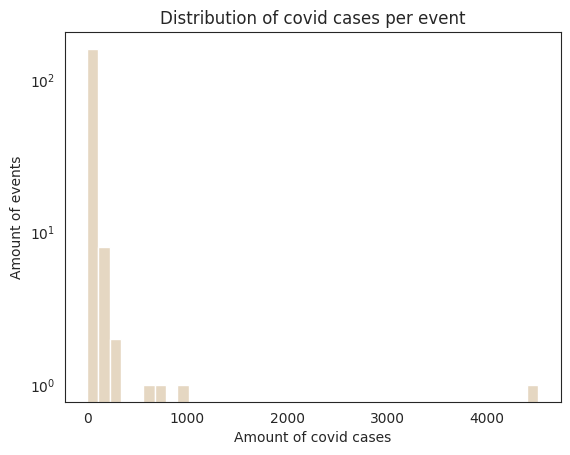

In [ ]:
plt.hist(cases["confirmed"], bins =40)
plt.yscale('log')
plt.xlabel('Amount of covid cases')
plt.ylabel('Amount of events')
plt.title('Distribution of covid cases per event');

We can see the far majority of events leads to a relatively low number of infections. More precisely, looking at the 75th percentile in the table above, it seems that about 75% of group and non-group events leads to 0-30 covid cases.

#### Policy data

In [ ]:
policy.head()

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN


In [ ]:
policy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   policy_id   61 non-null     int64 
 1   country     61 non-null     object
 2   type        61 non-null     object
 3   gov_policy  61 non-null     object
 4   detail      59 non-null     object
 5   start_date  61 non-null     object
 6   end_date    24 non-null     object
dtypes: int64(1), object(6)
memory usage: 3.5+ KB


There are no missing values, all columns except policy_id are of string/object type.

In [ ]:
policy['start_date'] = pd.to_datetime(policy['start_date'])
policy['end_date'] = pd.to_datetime(policy['end_date'])

In [ ]:
policy.nunique()

policy_id     61
country        1
type           8
gov_policy    24
detail        57
start_date    35
end_date      14
dtype: int64

* Since no province, region or city levels are present, and country only has one value, the dataset only contains information on a country level.
* There appear to be 8 types of policies
* There are 35 different dates at which new policies were introduced, only at 14 different dates policies were ended.

In [ ]:
missing_details = policy["detail"].isna()
policy[missing_details]

,policy_id,country,type,gov_policy,detail,start_date,end_date
50,51,Korea,Technology,Self-Diagnosis App,NaN,2020-02-12,NaT
51,52,Korea,Technology,Self-Quarantine Safety Protection App,NaN,2020-03-07,NaT


The only missing values are in the detail column, apparently there is no detail on the app introductions, however the gov_policy column values are pretty self-explanatory. Leaving these cases out would not be a good idea as we will miss out on information of policies that potentially have been effective, as they have been in place since the beginning and weren't ruled out, seeing they have no end date.

#### Floating data


In [ ]:
floating.head(5)

,date,hour,birth_year,sex,province,city,fp_num
0,2020-01-01,0,20,female,Seoul,Dobong-gu,19140
1,2020-01-01,0,20,male,Seoul,Dobong-gu,19950
2,2020-01-01,0,20,female,Seoul,Dongdaemun-gu,25450
3,2020-01-01,0,20,male,Seoul,Dongdaemun-gu,27050
4,2020-01-01,0,20,female,Seoul,Dongjag-gu,28880


In [ ]:
floating["province"].unique()

array(['Seoul'], dtype=object)

In [ ]:
floating.describe()

,hour,birth_year,fp_num
count,1084800.000,1084800.000,1084800.000
mean,11.483,45.000,27426.965
std,6.919,17.078,12695.048
min,0.000,20.000,3630.000
25%,5.000,30.000,18350.000
50%,11.000,45.000,25510.000
75%,17.000,60.000,33940.000
max,23.000,70.000,127640.000


* It looks like the birth_year column represents age group 20s to 70s, we will therefore rename it.
* The fp_num, assuming 'floating people number' we will rename into nr of people. fp_num seems to have an outlier on the max side. Seeing the mean and median are quite close to each other but the maximum is very far from the mean and 3rd quartile. Thus there is a lot of variety in the amount of movements per day.
* Data is only available for Seoul, thus we cannot compare between provinces.

In [ ]:
floating = floating.rename(columns={"birth_year":"age_group", "fp_num":"nr_of_people"})
floating['date'] = pd.to_datetime(floating['date'])

In [ ]:
# Check time ranges of datasets
start_date = floating["date"].min()
end_date = floating["date"].max()
print('earliest dates: ' + str(start_date))
print('latest dates: ' + str(end_date))

earliest dates: 2020-01-01 00:00:00
latest dates: 2020-05-31 00:00:00


In [ ]:
floating[floating["date"]== "2020-01-01"]

,date,hour,age_group,sex,province,city,nr_of_people
0,2020-01-01,0,20,female,Seoul,Dobong-gu,19140
1,2020-01-01,0,20,male,Seoul,Dobong-gu,19950
2,2020-01-01,0,20,female,Seoul,Dongdaemun-gu,25450
3,2020-01-01,0,20,male,Seoul,Dongdaemun-gu,27050
4,2020-01-01,0,20,female,Seoul,Dongjag-gu,28880
...,...,...,...,...,...,...,...
7195,2020-01-01,23,70,male,Seoul,Yangcheon-gu,13620
7196,2020-01-01,23,70,female,Seoul,Yeongdeungpo-gu,19810
7197,2020-01-01,23,70,male,Seoul,Yeongdeungpo-gu,14780
7198,2020-01-01,23,70,female,Seoul,Yongsan-gu,13470


The dataset has a time range from 1st jan to 31st may of 2020, and seems to be on date, hour, gender and city level combined. In combination this gives 7200 rows for each date in the dataset.

In [ ]:
# Check for dates that are having less than 7200 rows
counts_per_day = floating.groupby("date").count()
counts_per_day.query("hour < 7200")

,hour,age_group,sex,province,city,nr_of_people
date,,,,,,
2020-05-21,6900,6900,6900,6900,6900,6900
2020-05-29,5100,5100,5100,5100,5100,5100


In [ ]:
tofilter_out = ["2020-05-21", "2020-05-29"]
floating = floating[~floating['date'].isin(tofilter_out)]

In [ ]:
floating_bydate = floating.groupby("date")[["nr_of_people"]].sum()
floating_bydate

,nr_of_people
date,
2020-01-01,192406170
2020-01-02,202929360
2020-01-03,203337150
2020-01-04,197396050
2020-01-05,195747670
...,...
2020-05-26,199347850
2020-05-27,199293080
2020-05-28,199209840


After organising by date, only 149 rows in total are left. However, take into account that the date range is not complete as we filtered out 2 dates with missing cases. Thus to analyse by date we need to merge with a neutral date variable.

In [ ]:
floating_bydate.describe()

,nr_of_people
count,149.000
mean,197457044.027
std,15960666.123
min,158520180.000
25%,192426760.000
50%,198802810.000
75%,200093010.000
max,373087550.000


In [ ]:
# Calculate outliers
IQR = 200084555 - 192393845
upper_value = 200084555 + 1.5*IQR
lower_value = 192393845 - 1.5*IQR
print('The lower range is:',lower_value,'\nThe upper range is:', upper_value,)

The lower range is: 180857780.0 
The upper range is: 211620620.0


In [ ]:
floating_bydate = floating_bydate[(floating_bydate["nr_of_people"] < 211620620) &\
                                  (floating_bydate["nr_of_people"] > 180857780)]
floating_bydate["nr_of_people"] = (floating_bydate["nr_of_people"]/1000000).round(2)

### Part 2: Exploratory Analysis


#### Overall cases and deaths

* Positive test rate
* Covid case development over time
* Covid deaths over time


In [ ]:
population["population_mlns"] = population["population"]/1000000
print('In total there are', population["population_mlns"].sum().round(1),\
      'million people living in South Korea.')

In total there are 51.8 million people living in South Korea.


In [ ]:
# Since the time dataset is cumulative, take the data of the last date only
# to get totals for the whole period
time["prevalence"] = (time["confirmed"]/51821478)
time["positive_test%"] = time["confirmed"]/time["test"]*100
totalcases = time[time["date"] == '2020-06-30']
totalcases

,date,time,test,negative,confirmed,released,deceased,prevalence,positive_test%
162,2020-06-30,0,1273766,1240157,12800,11537,282,0.000,1.005


In [ ]:
# Display floats only with 2 decimals in the entire notebook
pd.options.display.float_format = '{:,.2f}'.format

The total amount of confirmed covid cases from 20th Jan to 30th June 2020, and thus the total amount of covid cases during the timespan of our dataset is 12800. This seems very low when comparing to countries in Europe with similar sized population or with even a lot smaller population, in the first 6 months of the pandemic https://ourworldindata.org/coronavirus/country/south-korea?country=KOR~NLD~ESP~JPN~GBR.
However, numbers could be impacted by how much testing was done.


In [ ]:
test_rates = time[time["positive_test%"] <100]
time[["date", "test", "negative", "confirmed", "positive_test%"]].set_index("date").head(7)

,test,negative,confirmed,positive_test%
date,,,,
2020-01-20,1,0,1,100.00
2020-01-21,1,0,1,100.00
2020-01-22,4,3,1,25.00
2020-01-23,22,21,1,4.55
2020-01-24,27,25,2,7.41
2020-01-25,27,25,2,7.41
2020-01-26,51,47,3,5.88


We notice that the start of the dataset seems to mark the start of covid testing, with positive test rate dropping from 100% to 6% in one week, while number of tests was increasing.

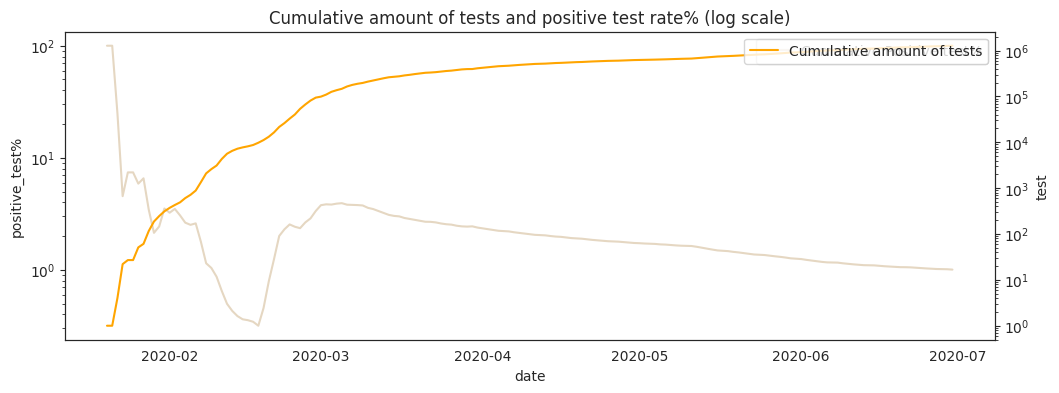

In [ ]:
plt.figure(figsize=(12,4))
ax = sns.lineplot(x=time["date"], y=time["positive_test%"], label="Cumulative Positive test%")
ax2 = ax.twinx()
sns.lineplot(x=time["date"], y=time["test"], ax=ax2, color="orange",\
             label="Cumulative amount of tests")
plt.legend(loc="upper right")
plt.title("Cumulative amount of tests and positive test rate% (log scale)")
ax.set_yscale('log')
ax2.set_yscale('log')

In the graph we can see the positive test rate seems to be jumping up and down in the beginning with numbers of tests increasing steeply until March. From March on, the amount of tests increases at a slower, more stable rate, while positive test rate is going down. Thus, this could indicate they had trouble ramping up their testing in the beginning, as was common in a lot of countries.

In [ ]:
# Create non-cumulative cases and deaths features to look at daily numbers
time["daily_confirmed"] = time["confirmed"].diff().fillna(0).astype(int)
time.iloc[0,7]=1
time["daily_deceased"] = time["deceased"].diff().fillna(0).astype(int)

In [ ]:
daily = time.groupby(pd.Grouper(key='date', freq='D'))
weekly = time.groupby(pd.Grouper(key='date', freq='W'))
newcases_day = daily['daily_confirmed'].sum()
newcases_week = weekly['daily_confirmed'].sum()
deaths_day = daily["daily_deceased"].sum()
deaths_week = weekly["daily_deceased"].sum()

In [ ]:
df_newcases_day = daily[['daily_confirmed']].sum()
max_daily_cases = time["daily_confirmed"].max()
df_deaths_day = daily[["daily_deceased"]].sum()
max_daily_deaths = time["daily_deceased"].max()

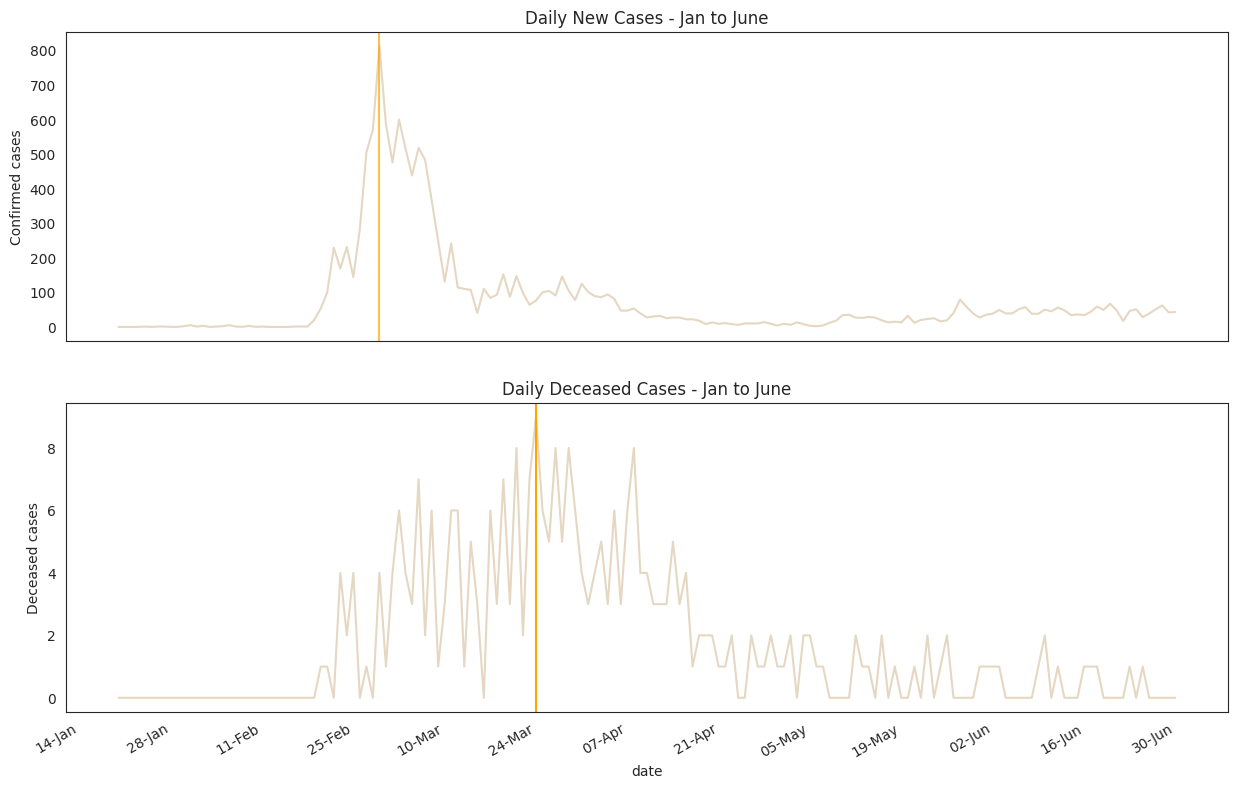

In [ ]:
def cases_time(series1, series2, ylabel1, ylabel2, title1, title2):
  fig, ax = plt.subplots(2,1, figsize=(15, 10))
  plt.subplots_adjust(wspace=0.1)
  plt.gcf().autofmt_xdate()
  sns.lineplot(x=series1.index, y=series1, ax=ax[0])
  sns.lineplot(x=series2.index, y=series2, ax=ax[1])
  tick_interval = 14
  locator = mdates.DayLocator(interval=tick_interval)
  formatter = mdates.DateFormatter('%d-%b')
  for axis in ax:
    axis.xaxis.set_major_formatter(formatter)
    axis.xaxis.set_major_locator(locator)
    #axis.set_xlabel('')
  ax[0].set_ylabel(ylabel1)
  ax[1].set_ylabel(ylabel2)
  ax[0].set_title(title1)
  ax[1].set_title(title2)
  ax[0].axvline(time[time["daily_confirmed"]==max_daily_cases]["date"],\
                alpha=0.7, color="orange")
  ax[1].axvline(time[time["daily_deceased"]==max_daily_deaths]["date"],\
                color="orange");

cases_time(newcases_day, deaths_day, 'Confirmed cases', 'Deceased cases',\
           "Daily New Cases - Jan to June", "Daily Deceased Cases - Jan to June")

New case development seems to have a more steep development in the beginning and after that slows down significantly, while the development of deaths seems to go more slowly with a later peak, almost a month after the peak in amount of cases.
The orange line represents the days with the peaks in cases and deaths. The overall highest amount of cases on one day was 813, on the 29th of February. The highest amount of deaths on one day was 9, at the 24th of March, thus there were 24 days between those two peaks.

In [ ]:
df_newcases_day[df_newcases_day["daily_confirmed"]==max_daily_cases]

,daily_confirmed
date,
2020-02-29,813


In [ ]:
df_deaths_day[df_deaths_day["daily_deceased"]==max_daily_deaths]

,daily_deceased
date,
2020-03-24,9


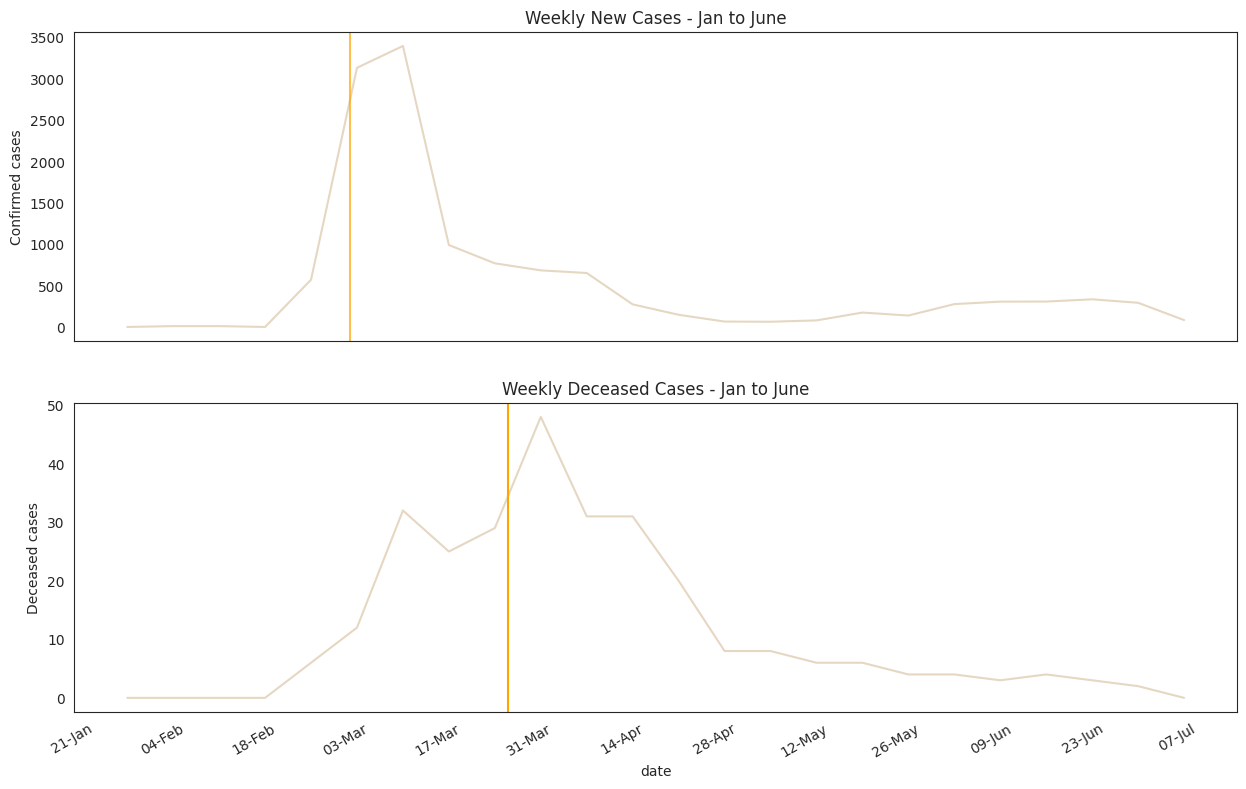

In [ ]:
cases_time(newcases_week, deaths_week, 'Confirmed cases', 'Deceased cases',\
           "Weekly New Cases - Jan to June", "Weekly Deceased Cases - Jan to June")

We can see that the peak days in both cases are not in the peak weeks, but before them. The speed at which new cases increased differs more over time than the deaths. The only real steep growth in new cases happened in the beginning and then smoothed down. Rate at which deaths were increasing is overall slower.  

#### Gender
* How do number of cases and deaths differ between genders?
* Does the development of cases and deaths over time differ between genders?

In [ ]:
# Take the data of the last date only to get totals for the whole period
total_gender = timegender[timegender["date"] == '2020-06-30']
total_gender = total_gender.iloc[:, 2:5].set_index("sex")
total_gender["death_rate%"] = (total_gender["deceased"]/total_gender["confirmed"])*100
total_gender

,confirmed,deceased,death_rate%
sex,,,
male,5495,151,2.75
female,7305,131,1.79


Looking at total amount of covid cases per gender from March to June 2020, we clearly see that there were many more confirmed cases amongst women, however the death rate is quite a lot lower for women than for men.

Below we check whether the development of new cases and deaths over time differs between men and women.

In [ ]:
female = timegender.query("sex == 'female'")[["date", "confirmed", "deceased"]]
male = timegender.query("sex == 'male'")[["date", "confirmed", "deceased"]]

In [ ]:
# Create features for daily counts and 7 day rolling averages per gender
def create_dailycount(df, var1, newvar1, newvar2):
  df[newvar1] = df[var1].diff().fillna(0).astype(int)
  df[newvar2] = df[newvar1].rolling(window=7).mean()

create_dailycount(female, "confirmed", "daily_confirmed", "rolling_confirmed")
create_dailycount(female, "deceased", "daily_deceased", "rolling_deceased")
create_dailycount(male, "confirmed", "daily_confirmed", "rolling_confirmed")
create_dailycount(male, "deceased", "daily_deceased", "rolling_deceased")

In [ ]:
x = timegender["date"]
dates = pd.date_range(start=x.min(), end=x.max(), freq='D')

#Def create_lineplots(df1: pd.DataFrame, df2: pd.DataFrame, var1: str, var2: str, ylabel: str, legend_position: str, title1: str, title2: str) -> None:

def create_lineplots(df1, df2, var1, var2, ylabel, legend_position, title1, title2):
  fig, ax = plt.subplots(2, 1, figsize=(10, 10))
  plt.subplots_adjust(wspace=0.5)
  plt.gcf().autofmt_xdate()
  ax[0].plot(dates, df1[var1], color='orange', label='female')
  ax[0].plot(dates, df2[var1], label='male')
  ax[1].plot(dates, df1[var2], color='orange')
  ax[1].plot(dates, df2[var2])
  tick_interval = 14
  locator = mdates.DayLocator(interval=tick_interval)
  formatter = mdates.DateFormatter('%d-%b')
  for axis in ax:
    axis.xaxis.set_major_locator(locator)
    axis.xaxis.set_major_formatter(formatter)
    axis.set_ylabel(ylabel)
    axis.legend(loc=legend_position)
    axis.locator = mdates.DayLocator(interval=tick_interval)
    axis.formatter = mdates.DateFormatter('%d-%b')
  ax[1].set_ylabel("Deceased Cases")
  ax[0].set_title(title1)
  ax[1].set_title(title2);

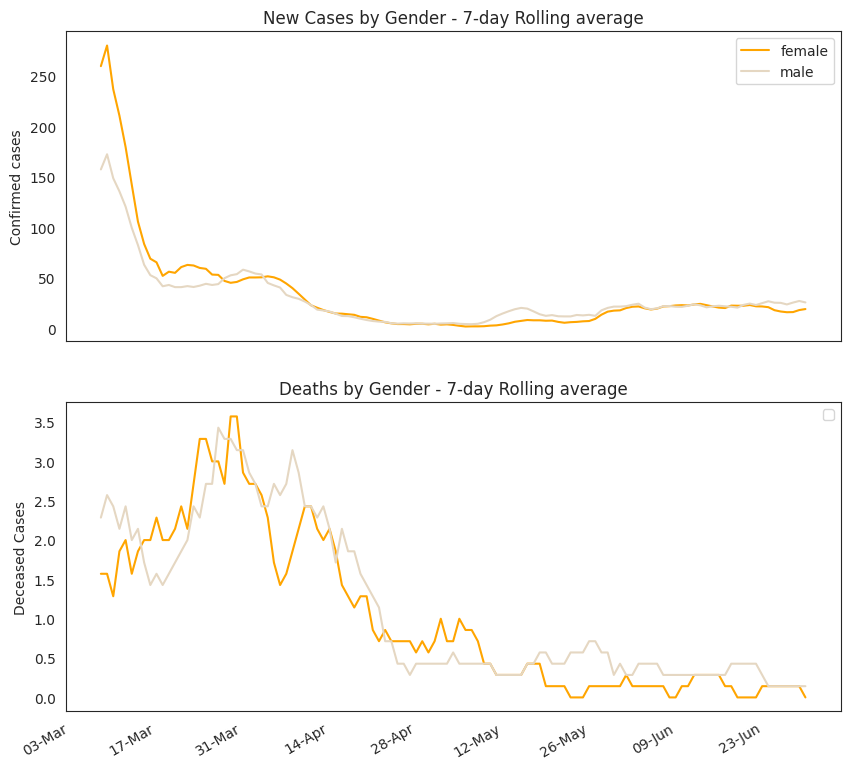

In [ ]:
create_lineplots(female, male, 'rolling_confirmed', 'rolling_deceased',\
                 ylabel='Confirmed cases',legend_position='upper right',\
                 title1='New Cases by Gender - 7-day Rolling average',\
                 title2='Deaths by Gender - 7-day Rolling average');

Note that compared to the graph for overall cases the peak seemed to come sooner here, however this is because the data range differs, gender data is only available from March.
* For women, the amount of cases peaks a lot higher in the beginning than for men, for the rest new case development is following a similar pattern.
* Looking at the trend of deceased cases, we can see that the patterns are often reversed in terms of peaks and downs. However, when looking at the cumulative distribution below, the development seems to go at the same speed.
* Note that from the cumulative grapsh it beomes clear that there are more female confirmed cases but more male deaths, as coloured lines are reversed in the below graphs.  


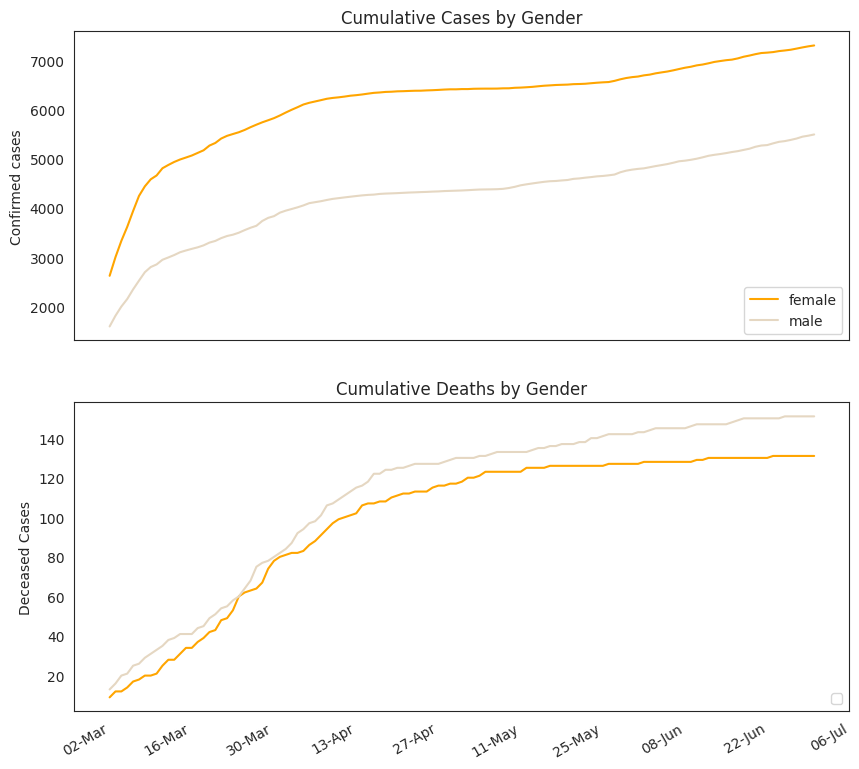

In [ ]:
create_lineplots(female, male, 'confirmed', 'deceased', ylabel='Confirmed cases',\
                 legend_position='lower right', title1='Cumulative Cases by Gender',\
                 title2='Cumulative Deaths by Gender');

#### Age
* How do covid cases and deaths differ between age groups?
* Does the development over time differ?

In [ ]:
# Take the data of the last date only to get totals for the whole period
total_cases = timeage[timeage["date"] == '2020-06-30']
age_groups = total_cases.iloc[:, 2:5].set_index("age")
age_groups["death_rate%"] = age_groups["deceased"]/age_groups["confirmed"]*100
age_groups

,confirmed,deceased,death_rate%
age,,,
0s,193,0,0.00
10s,708,0,0.00
20s,3362,0,0.00
30s,1496,2,0.13
40s,1681,3,0.18
50s,2286,15,0.66
60s,1668,41,2.46
70s,850,82,9.65
80s,556,139,25.00


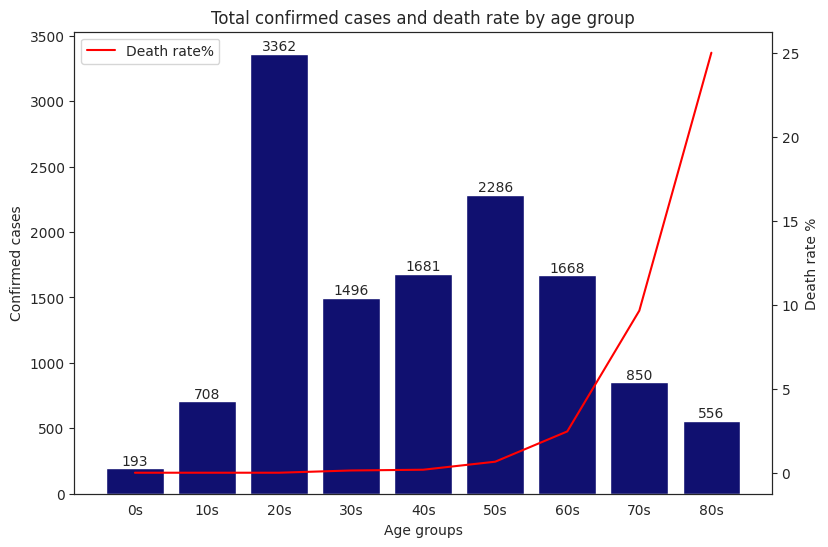

In [ ]:
plt.figure(figsize=(9,6))
ax = sns.barplot(x=age_groups.index, y=age_groups["confirmed"], color="navy")
ax2 = ax.twinx()
sns.lineplot(x=age_groups.index, y=age_groups["death_rate%"], ax=ax2,\
             label="Death rate%", color="red")
ax.set_title("Total confirmed cases and death rate by age group")
ax.set_xlabel('Age groups')
ax.set_ylabel('Confirmed cases')
ax2.set_ylabel('Death rate %')
for i, v in enumerate(age_groups["confirmed"]):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10);

* Highest amount of cases was clearly in the 20s age group, while numbers for 50s seem relatively high too. Number of covid cases amongst 40s and 60s were roughly equal. The amount of cases seems to be lowering after 50, especially for 70s and 80s, however these are likely to be smaller population groups.
* Death rate clearly increases with age in general, and especially steeply from 60s on.

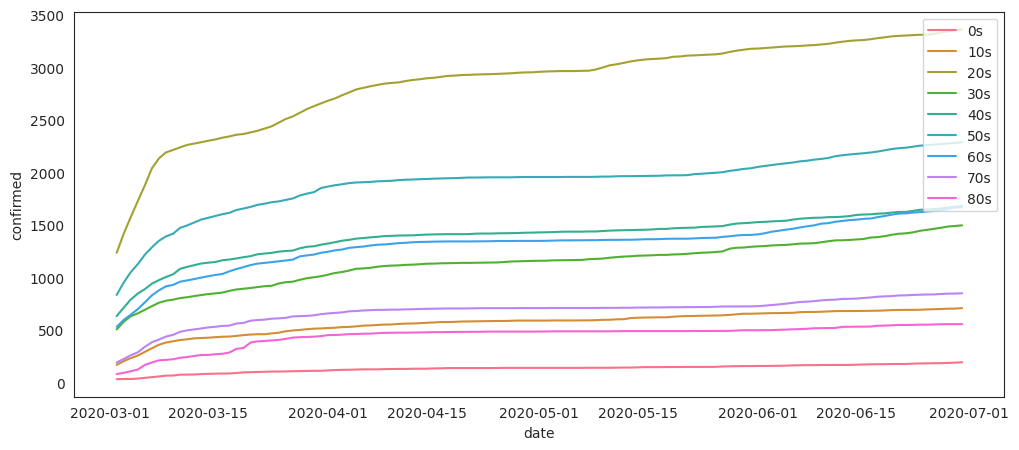

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x=timeage['date'], y=timeage["confirmed"], hue=timeage["age"])
plt.legend(loc='upper right');

The development of new cases looks pretty similar for the age groups, except in the beginning where 20s and 50s take a jump, and towards the end 20s to 60s seem to increase faster.

Now we could wonder whether the provinces with more covid cases have a younger population on average, and in particular a lot of people in their twenties.

#### Provinces

* Are there more covid cases in provinces with a larger population and provinces that are more densely populated?
* Are provinces with more covid cases also the ones with more deaths?


In [ ]:
population["population_mlns"] = population["population"]/1000000
print('In total there are', population["population_mlns"].sum().round(1),\
      'million people living in South Korea.')

In total there are 51.8 million people living in South Korea.


In [ ]:
def create_twinxplot(df, var_bar, var_line, linelable, bar_ylabel, line_ylabel, title):
  plt.figure(figsize=(13,6))
  ax = sns.barplot(x=df.index, y=df[var_bar], palette="ch:.25")
  ax2 = ax.twinx()
  sns.lineplot(x=df.index, y=df[var_line], ax=ax2, label=linelable, color="grey")
  plt.gcf().autofmt_xdate()
  ax.set_ylabel(bar_ylabel)
  ax2.set_ylabel(line_ylabel)
  plt.title(title)
  for i, v in enumerate(df[var_bar]):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10);


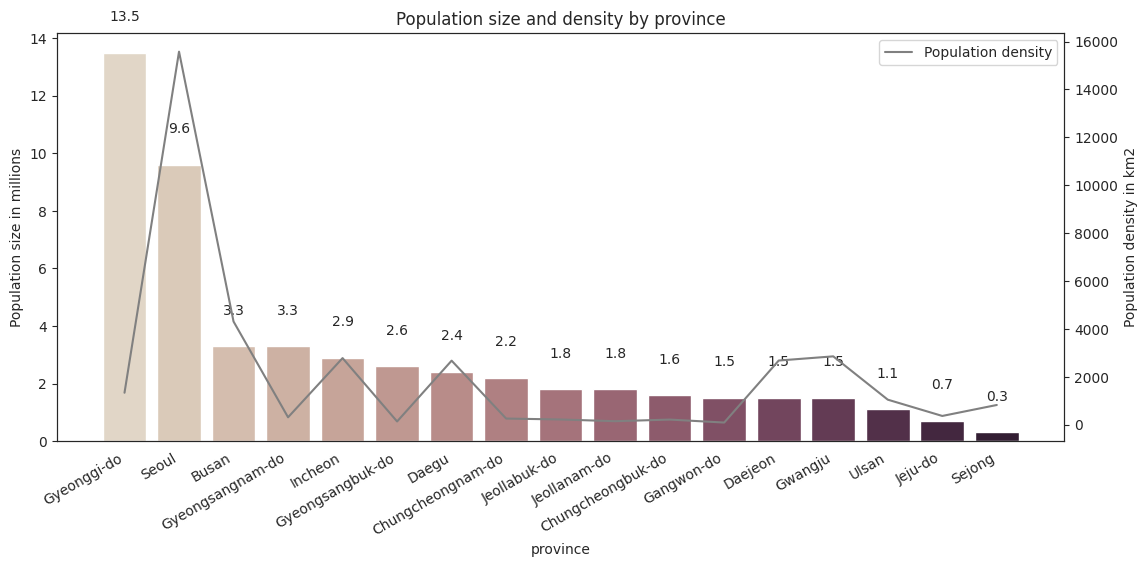

In [ ]:
population_ordered = population.set_index("province").sort_values("population_mlns",\
                                                                  ascending=False).round(1)
create_twinxplot(population_ordered, "population_mlns", "population_density",\
                 "Population density", "Population size in millions",\
                 "Population density in km2", "Population size and density by province")

The regions with the largest populations are clearly Gyenonggi-do (13,5M) and Seoul (9,6M). All the others have less than 4 million inhabitants, the smallest is Sejong (0,3M). Seoul is by far the most densely populated.

In [ ]:
# Create data frame for totals over the entire period
provinces_cases = timeprovince[timeprovince["date"] == '2020-06-30'].iloc[:, 2:6]
provinces_cases["death_rate"] = ((provinces_cases["deceased"] / provinces_cases["confirmed"]) * 100).round(2)

In [ ]:
provinces_all = pd.merge(provinces_cases, population, on="province")
provinces_all["prevalence"] = ((provinces_all["confirmed"]/provinces_all["population"])*100)
provinces_all.set_index('province', inplace=True)
provinces_all.sort_values("confirmed", ascending=False)
provinces_all[["confirmed", "population", "population_density", "prevalence",\
               "deceased", "death_rate"]].sort_values("confirmed", ascending=False).head(10)

,confirmed,population,population_density,prevalence,deceased,death_rate
province,,,,,,
Daegu,6906,"2,410,700.00","2,675.25",0.29,189,2.74
Gyeongsangbuk-do,1389,"2,644,757.00",136.64,0.05,54,3.89
Seoul,1312,"9,586,195.00","15,578.16",0.01,7,0.53
Gyeonggi-do,1207,"13,511,676.00","1,336.10",0.01,23,1.91
Incheon,341,"2,945,454.00","2,782.40",0.01,1,0.29
Chungcheongnam-do,167,"2,176,636.00",258.08,0.01,0,0.00
Busan,154,"3,349,016.00","4,309.46",0.00,3,1.95
Gyeongsangnam-do,134,"3,333,056.00",311.26,0.00,0,0.00
Daejeon,117,"1,488,435.00","2,681.14",0.01,1,0.85


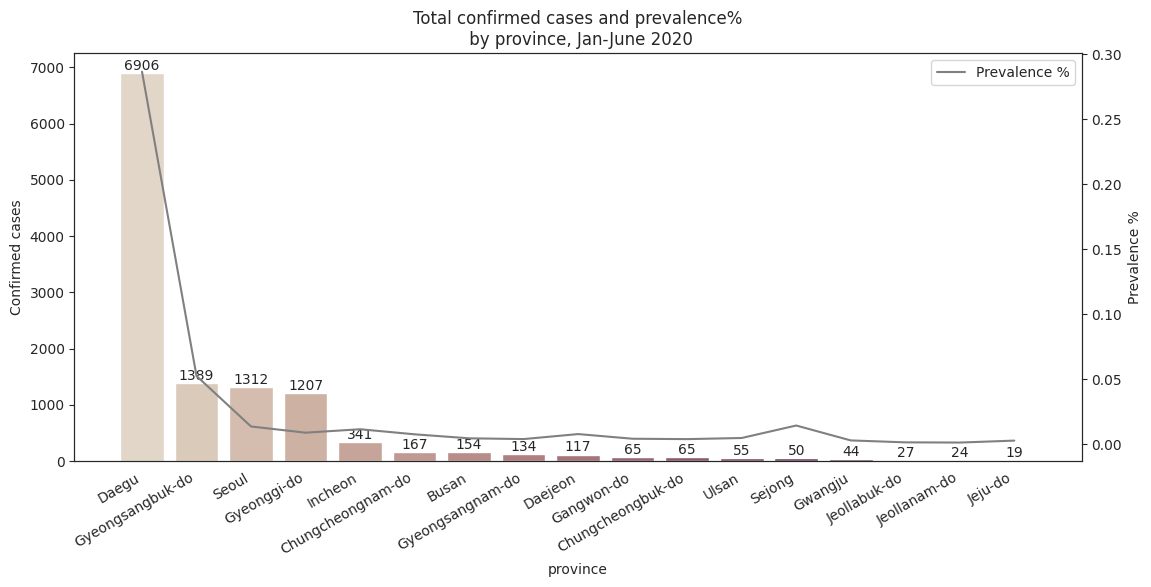

In [ ]:
province_stats = provinces_all.sort_values("confirmed", ascending=False)
create_twinxplot(province_stats, "confirmed", "prevalence", "Prevalence %",\
                 "Confirmed cases", "Prevalence %",\
                 "Total confirmed cases and prevalence%\n by province, Jan-June 2020")

* The province Daegu has by far most confirmed cases and highest prevalence. Overall, the prevalence is very low, only Daegu has a prevalence over 0.05%
* The largest province in terms of population: Gyeonggi-do, is only 4th largest in number of covid cases and prevalence.
* The most densely populated province of Seoul is 3rd highest in number of covid cases.

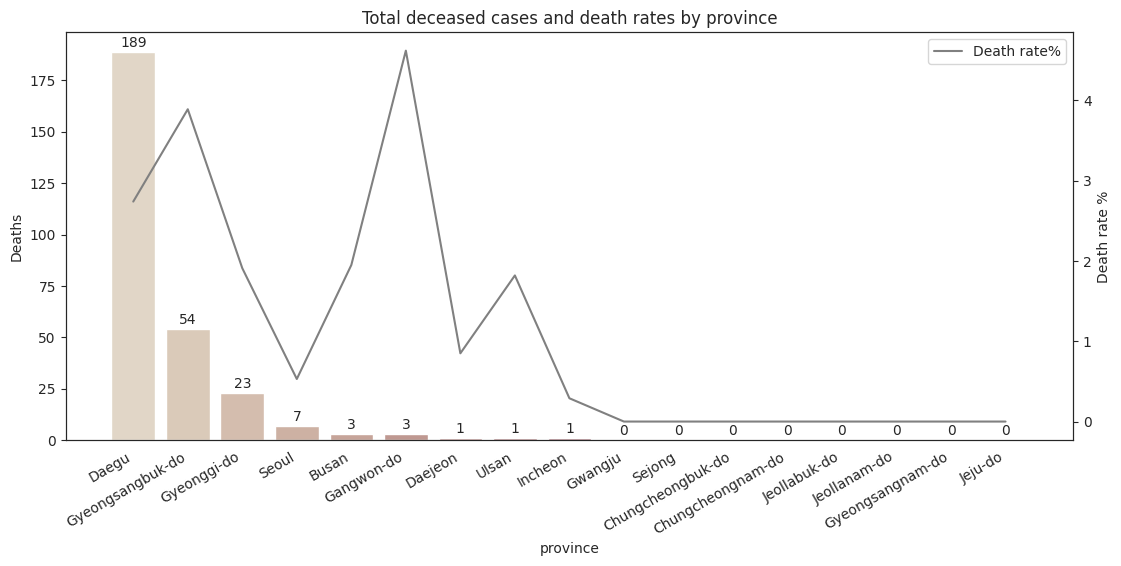

In [ ]:
province_deceased = provinces_all.sort_values("deceased", ascending=False)
create_twinxplot(province_deceased, "deceased", "death_rate", "Death rate%", "Deaths",\
                 "Death rate %", "Total deceased cases and death rates by province")

* Death rate seems to vary between 0 and 5%, and differs a lot between provinces.
* Daegu clearly has the highest absolute number of deaths. Death rate is highest for Gangwon-do, however just 3 deaths on 65 confirmed cases, based on which it would be tricky to draw conclusions.
* The 2nd to 4th provinces with highest amounts of deahts are the same that were highest in amount of cases, but in mixed order. Two of those were also amongst the highest in population size.

Overall, we might wonder the following:
* Why are cases in Daegu so much higher than in other provinces?
* What makes the death rate so low in Seoul, while having relatively a lot of covid cases?
* What sets provinces with zero covid deaths apart?

We might wonder whether population size and absolute amount of covid cases are correlated, as the top ones are partly the same provinces.


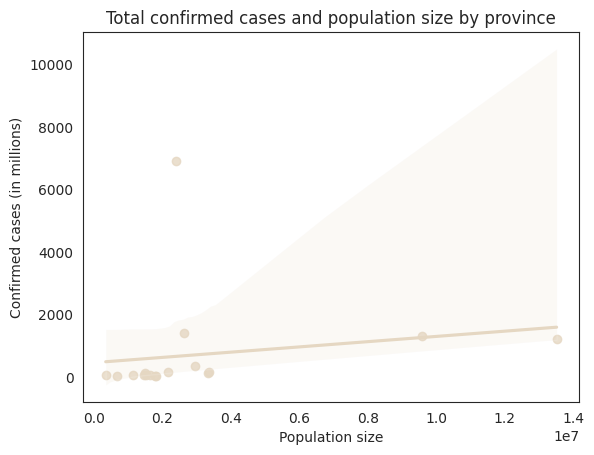

In [ ]:
sns.regplot(x=provinces_all["population"], y=provinces_all["confirmed"])
plt.xlabel("Population size")
plt.ylabel("Confirmed cases (in millions)")
plt.title("Total confirmed cases and population size by province");

There seems to be some kind of trend however the line is almost horizontal, and with a large error margin. Also there is a clear outlier in the amount of confirmed cases

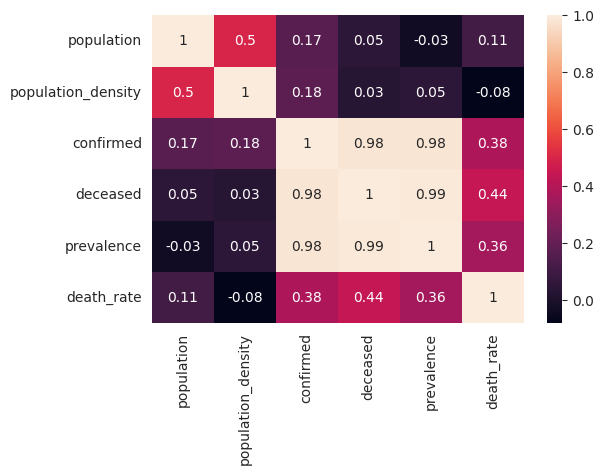

In [ ]:
plt.figure(figsize=(6,4))
corr_subset2 = provinces_all[['population', 'population_density', 'confirmed',\
                              'deceased', 'prevalence', 'death_rate']]
corr_matrix = corr_subset2.corr().round(2)
sns.heatmap(corr_matrix, annot=True);

Looking at the above, no clear pattern can be detected, population size and density seem not correlated to confirmed cases, deceased, prevalence or death_rate on a province level.

Therefore, we will search for explanantions in group cases data, in order to find out whether higher prevalence is due to massive events which led to a lot of covid infections at once.

#### Infection sources
Can events that caused a large number of cases at once, explain differences in amount of covid cases between provinces?

In [ ]:
total_withsource = cases["confirmed"].sum()
total_withsource

11395

In [ ]:
cases.groupby("group")[["confirmed"]].sum().rename(columns={"group":"group event"})

,confirmed
group,
False,3544
True,7851


The cases dataset provides information on the infection source of 11395 confirmed cases, of which the majority seems to come from group events.


In [ ]:
group_events = cases[cases["group"]== True]
top10_events = group_events[["infection_case", "confirmed", "province"]]\
.set_index("infection_case").sort_values("confirmed", ascending=False).head(10)
top10_events

,confirmed,province
infection_case,,
Shincheonji Church,4511,Daegu
Shincheonji Church,566,Gyeongsangbuk-do
Second Mi-Ju Hospital,196,Daegu
Itaewon Clubs,139,Seoul
Hansarang Convalescent Hospital,124,Daegu
Cheongdo Daenam Hospital,119,Gyeongsangbuk-do
Richway,119,Seoul
gym facility in Cheonan,103,Chungcheongnam-do
Daesil Convalescent Hospital,101,Daegu


* Looking at top 10 group events that led to most infections, we can see that the biggest event was related to the Shincheonji Church, and is the top source of infections for two provinces at least. Confirmed numbers per event are going down quickly in this list, as the 10th most infectuous event led to only 95 cases.
* All the largest covid spreading events above took place in one of the 4 provinces with most confirmed cases.
* The biggest group event is clearly one explanation for the high amount of cases in the province of Daegu, as it led to 4511 covid cases in Daegu alone.

In [ ]:
group_cases = group_events.groupby("province")[["confirmed"]].sum().rename(columns={"confirmed":"group_cases"})
merged_groupevents = pd.merge(provinces_cases, group_cases, on="province").set_index("province")
merged_groupevents["%group_cases"] = merged_groupevents["group_cases"]/merged_groupevents["confirmed"]*100
merged_groupevents[["group_cases", "confirmed", "%group_cases"]].sort_values("confirmed", ascending=False).head(10)

,group_cases,confirmed,%group_cases
province,,,
Daegu,4975,6906,72.04
Gyeongsangbuk-do,979,1389,70.48
Seoul,720,1312,54.88
Gyeonggi-do,548,1207,45.40
Incheon,117,341,34.31
Chungcheongnam-do,128,167,76.65
Busan,71,154,46.10
Gyeongsangnam-do,80,134,59.70
Daejeon,86,117,73.50


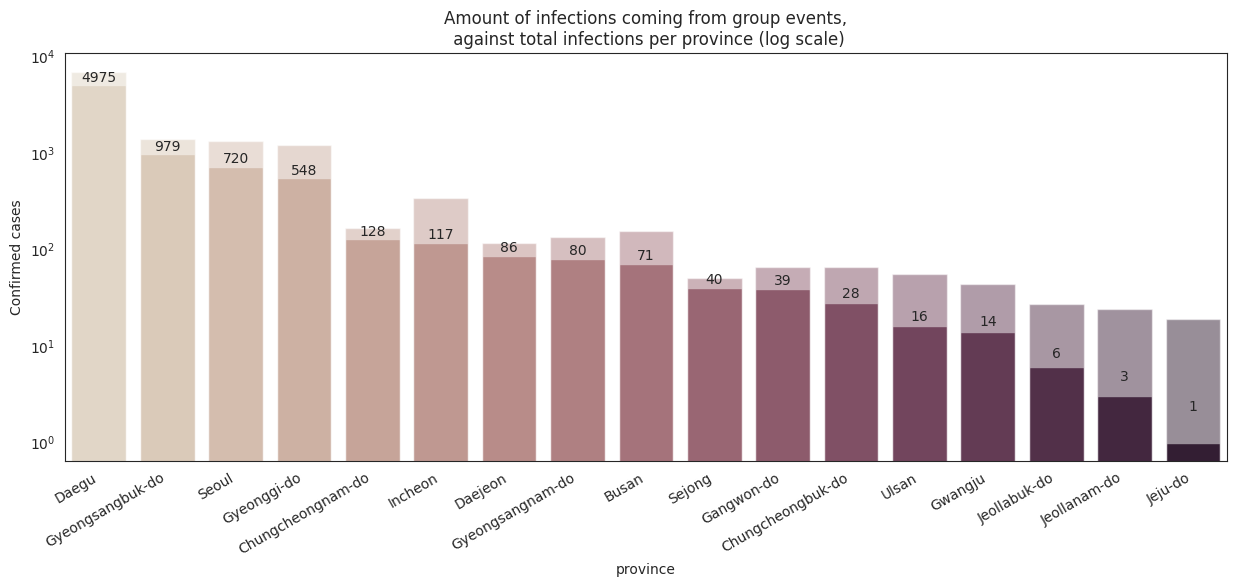

In [ ]:
merged_groupevents = merged_groupevents.sort_values("group_cases", ascending=False)
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=merged_groupevents.index, y=merged_groupevents["group_cases"],\
                 errorbar=None, palette="ch:.25")
ax = sns.barplot(x=merged_groupevents.index, y=merged_groupevents["confirmed"],\
                 alpha=0.5, palette="ch:.25")
plt.gcf().autofmt_xdate()
plt.ylabel('Confirmed cases')
plt.yscale('log')
plt.title("Amount of infections coming from group events,\n against total\
 infections per province (log scale)")
for i, v in enumerate(merged_groupevents["group_cases"]):
  ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10);

We can see that 72% of infections in Daegu are coming from group events. For the next two provinces with highest covid cases overall, also over 50% comes from group events.It varies a lot between provinces which % this is.
We might wonder whether there is a correlation between amount of group event cases and amount of total cases.  

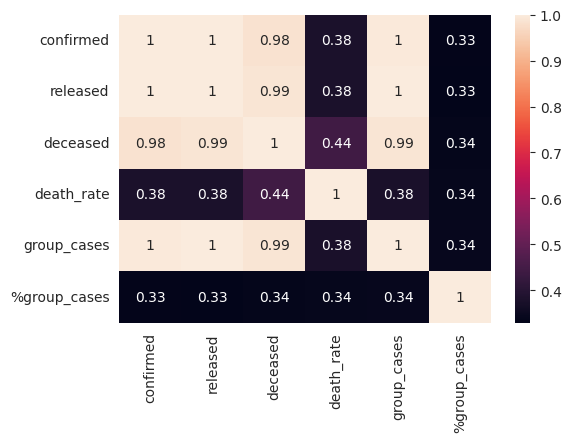

In [ ]:
plt.figure(figsize=(6,4))
corr_matrix = merged_groupevents.corr()
sns.heatmap(corr_matrix, annot=True);

The correlations indicate that the overall numbers of confirmed, released and deceased go up and down via the same pattern as the amount of group cases, which is no surprise as we saw that the majority of cases in general is from group events.
However, there was still a significant amount of cases coming from non-group events, of which we explore the causes below.

In [ ]:
non_group_events = cases[cases["group"]== False]
non_group_infection_cases = non_group_events.groupby("infection_case")[["confirmed"]].sum()
non_group_infection_cases["%of_total_cases"] = non_group_infection_cases["confirmed"]\
/total_withsource*100
non_group_infection_cases

,confirmed,%of_total_cases
infection_case,,
contact with patient,1403,12.31
etc,1192,10.46
overseas inflow,949,8.33


The non-group or individual case sources are categorised into 3 types, however, especially the 'etc' values aren't very informative. The total amount of cases coming from each type is still relatively large, recalling most group events led to 1-10 infections. This might differ a lot between provinces.


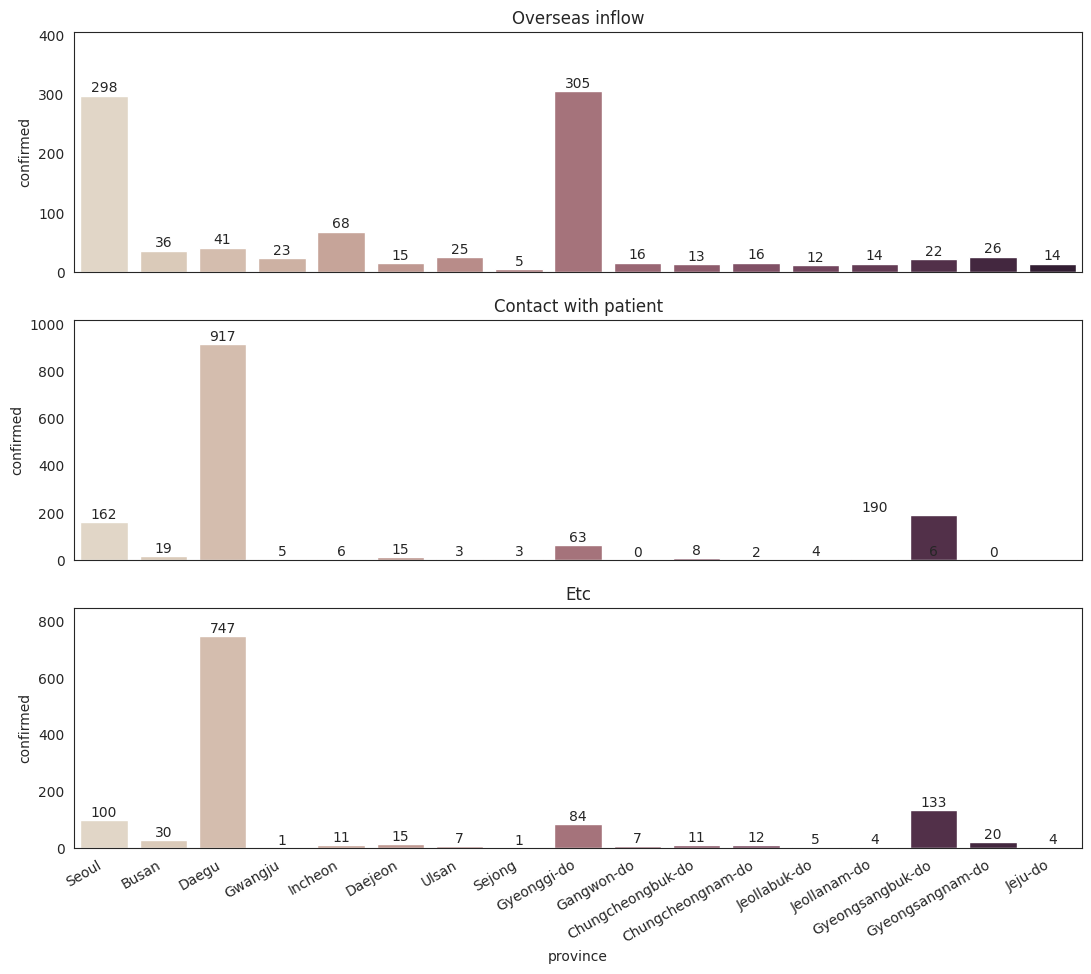

In [ ]:
causes = non_group_events["infection_case"].unique()
fig, ax = plt.subplots(len(causes),1,figsize=(13,12))
#df[df[y] == xs[i]]
for i in range(len(causes)):
  sns.barplot(x=non_group_events["province"], y=non_group_events[non_group_events\
   ["infection_case"]==causes[i]]["confirmed"], ax=ax[i], errorbar=None, palette="ch:.25")
  ax[i].set_title(f'{causes[i]}'.capitalize())
  plt.gcf().autofmt_xdate()
  ax[i].set_ylim(0, (non_group_events[non_group_events["infection_case"]==causes[i]]["confirmed"]).max()+100)
  for t, v in enumerate(non_group_events[non_group_events["infection_case"]==causes[i]]["confirmed"]):
    ax[i].text(t, v + 1, str(v), ha='center', va='bottom', fontsize=10)
# stacked barchart

#### Policies over time

* Which types of policies are there, and how many?
* When new policies came into place, what seemed the trigger to increase restrictions: was it the speed of covid spreading, increases in deaths, death rate, specific group events?


In [ ]:
measures = policy["start_date"].count()
measures_ended = policy["end_date"].count()
print('In total,', measures, 'covid measures have been implemented by the South Korean\n'
      'government between Jan and June, of which', (measures - measures_ended),\
      'were still in place at the end of June.')

In total, 61 covid measures have been implemented by the South Korean
government between Jan and June, of which 37 were still in place at the end of June.


In [ ]:
first_policy = policy["start_date"].min()
last_policy = policy["start_date"].max()
print('First policy implementation date: ' + str(first_policy))
print('Latest policy implementation date: ' + str(last_policy))

First policy implementation date: 2020-01-03 00:00:00
Latest policy implementation date: 2020-06-10 00:00:00


It seems like there have been policies implemented pretty much over the whole date range of our dataset.

In [ ]:
# Check which types of policies and how many of each have been in place
policy_count = policy.groupby("type")[["start_date", "end_date"]].count()
policy_count.sort_values("start_date", ascending=False)

,start_date,end_date
type,,
Education,15,14
Immigration,15,0
Health,10,1
Technology,6,0
Social,5,3
Alert,4,3
Administrative,3,2
Transformation,3,1


There are 8 types of policies, most of which were related to education, immigration or health. Most education related policies had been ended within the 6 months, whereas all immigration and technology measures, and most health related ones, were still in place at the end of June 2020.

In [ ]:
# Create dataframe to visualise amount of policies in place by date
timeline = pd.date_range(start="2020-01-01", end="2020-06-30", freq='D')
datedf = pd.DataFrame({'date': timeline})
policy_start = policy.groupby("start_date")["policy_id"].count()
policy_end = policy.groupby("end_date")["policy_id"].count()
start_dates = pd.merge(datedf, policy_start, left_on="date", right_on="start_date", how="left")
all_dates = pd.merge(start_dates, policy_end, left_on="date", right_on="end_date", how="left")
all_dates.fillna(0, inplace=True)
policies_bydate = all_dates.set_index("date").rename(columns=\
 {"policy_id_x":"policies_starting", "policy_id_y":"policies_ending"})
policies_bydate["policies_in_place"] = policies_bydate["policies_starting"]\
.cumsum() - policies_bydate["policies_ending"].cumsum()

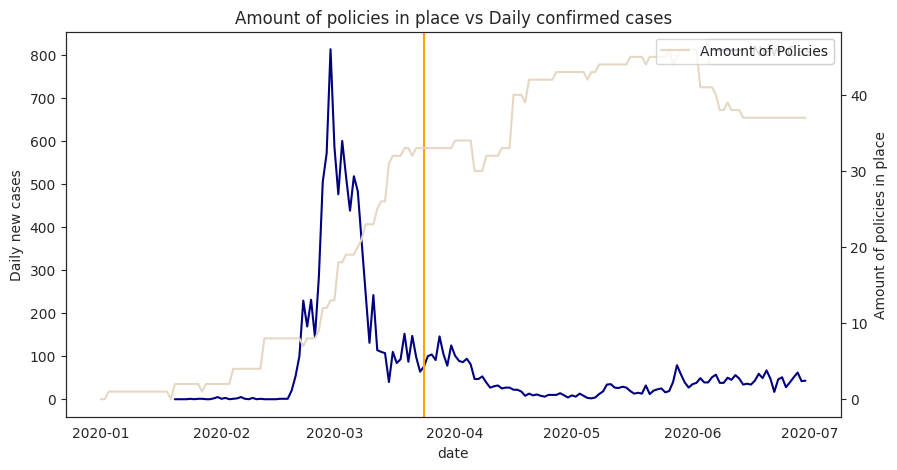

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=newcases_day.index, y=newcases_day, color="navy", label="New Cases")
ax2 = ax.twinx()
sns.lineplot(x=policies_bydate.index, y=policies_bydate["policies_in_place"], ax=ax2, label="Amount of Policies")
ax.set_ylabel("Daily new cases")
ax2.set_ylabel("Amount of policies in place")
ax.set_title("Amount of policies in place vs Daily confirmed cases")
ax.axvline(time[time["daily_deceased"]==max_daily_deaths]["date"], color="orange")
plt.legend(loc="upper right");

What is standing out is:
* The government started taking measures quite a while before the first infection, which they let go off again just before the first infection happened (notice the little drop). Right after the first infection they put back it in place together with a few more. Thus, this could show they were pro-active but also doubting what the right moment was to take measures.
* When infections were rising sharply towards the end of February, number of policies was also rising sharply. The policy line shows only little plateaus, meaning they were bringing in more policies almost every day, and not just one at a time, but mostly a couple at the same time.
* At the end of March, when the first peak of infections seemed to go down steadily, we notice a little plateau, meaning they didn't loosen measures when things seemed to get better, they just didn't bring in any new. It might be because the number of deaths was still on the rise here as the peak wasn't reached yet (orange line).
* When cases further dropped, some policies were let go off, but soon after, new ones came into place halfway april, while cases were actually dropping and stabilising.
* The moment with the highest amount of policies in place came at the end of May, beginning June. After that quite a few were dropped at once, after which cases remained around the same level. We might wonder whether this had something to do with the season and weather.

Overall, the government seemed pro-active with implementing new measures, and hesitant to let go of measures.

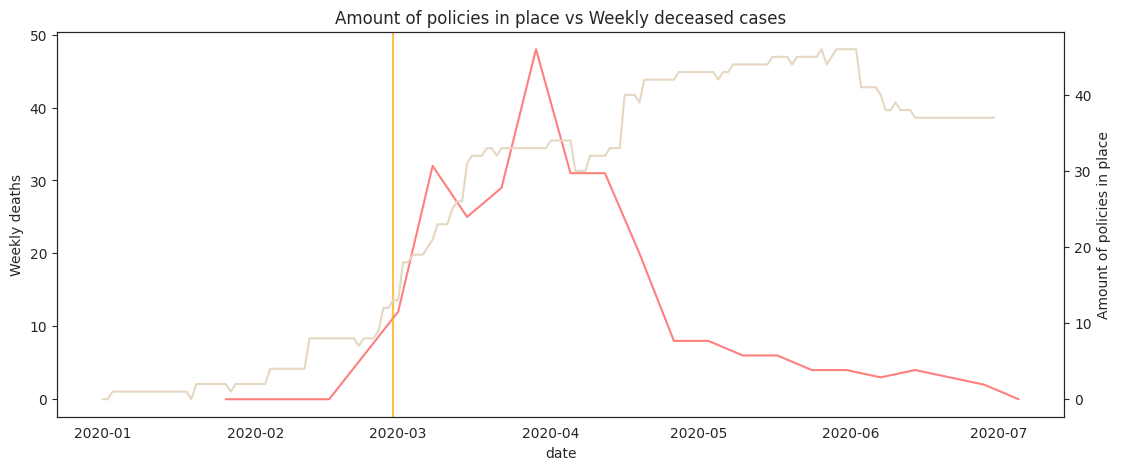

In [ ]:
plt.figure(figsize=(13, 5))
ax = sns.lineplot(x=deaths_week.index, y=deaths_week, color="red", alpha=0.5)
ax2 = ax.twinx()
sns.lineplot(x=policies_bydate.index, y=policies_bydate["policies_in_place"], ax=ax2)
ax.set_ylabel("Weekly deaths")
ax2.set_ylabel("Amount of policies in place")
ax.set_title("Amount of policies in place vs Weekly deceased cases")
ax.axvline(time[time["daily_confirmed"]==max_daily_cases]["date"], alpha=0.7, color="orange");

Here we can see that in March policies were kept in place likely because the amount of deaths wasn't decreasing yet when the peak of new infections was already over.
When the amount of deaths started dropping, some policies were dropped too, however as the initial drop stopped, more policies were put in place again, after which deaths dropped steeply until beginning of May.

#### Policy duration
* What can we say about the average duration of a policy? And the average duration per type of policy?
* Does this differ much between types of policies?

When looking at averages for policy duration, we need to take into account that quite a big part did not end yet at the end of our date range. Note that for these cases a the last date of our dataset 30-06-2020 has been filled as end date, in order to be able to calculate duration for comparison purposes.

In [ ]:
policy["duration"] = policy["end_date"]-policy["start_date"]
policy["has_ended"] = np.where(policy["duration"].isna() == False, "yes", "no")
policy["end_date_placeholder"] = policy["end_date"]
policy["end_date_placeholder"].fillna("2020-06-30", inplace=True)
policy["duration_all"] = policy["end_date_placeholder"] - policy["start_date"]
policy["duration_all"] = policy["duration_all"].dt.days
policy.isna().sum()

policy_id                0
country                  0
type                     0
gov_policy               0
detail                   2
start_date               0
end_date                37
duration                37
has_ended                0
end_date_placeholder     0
duration_all             0
dtype: int64

In [ ]:
policy[["duration_all"]].describe()

,duration_all
count,61.00
mean,76.80
std,45.16
min,7.00
25%,35.00
50%,75.00
75%,114.00
max,162.00


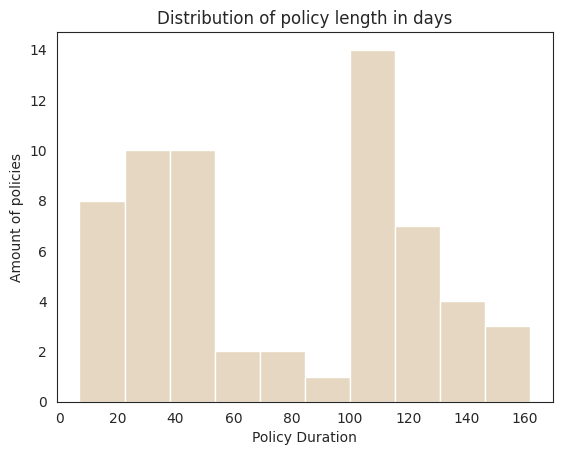

In [ ]:
plt.hist(policy["duration_all"], bins=10)
plt.xlabel('Policy Duration (days)')
plt.ylabel('Amount of policies')
plt.title('Distribution of policy duration in days');

In [ ]:
policy.groupby("has_ended")[["duration_all"]].mean()

,duration_all
has_ended,
no,105.38
yes,32.75


* Clearly the policies that have ended, had a shorter average duration.
* Taking all ended and unended policies into account, on average a policy stays in place for 77 days.  
* There is a lot of variety between policy types in the average amount of days policies stayed in place. It seems like most are either in place for up to 50 days, or over a 100 days. There aren't many of medium length.


In [ ]:
policytype_duration = policy.groupby("type")[["duration_all"]].mean()\
.rename(columns={"duration_all":"mean_duration"})
policytype_data = pd.merge(policy_count, policytype_duration, on="type")
policytype_data.sort_values("mean_duration", ascending=False)

,start_date,end_date,mean_duration
type,,,
Health,10,1,114.00
Immigration,15,0,111.33
Technology,6,0,102.33
Education,15,14,48.07
Alert,4,3,44.00
Social,5,3,38.80
Administrative,3,2,29.33
Transformation,3,1,27.33


* The policies staying in place longest are health related, together with immigration and technology policies. Shortest in place are transformation and administrative type of policies. These are also the types of which there are the fewest.
* Education policies are the type of which most have ended, however this might not have been because they weren't effective, but potentially they were seen as the ones they wanted to end the most badly, which could have been the case for more types of measures.

### Part 3: Summary of findings

* Overall covid development in the first 6 months of 2020 are marking a clear peak in the beginning, after which the amount of infections got under control quickly. The amount of deceased cases shows a flatter pattern and the peak in daily deaths comes about 24 days after the peak in daily infections.
* Amount of covid cases differs highly between provinces and does not seem to have a relation with population density.
* Clearly the majority of reported infections comes from group events, about 70%.
However, still a large part is coming from individual cases like contact with a patient, or overseas inflow. The ratio between these differs a lot between provinces.  
* Policywise, it seems like the government took a pro-active approach to prevent covid from spreading, the first policy was implemented before the first infection, and new immigration policies came into place rapidly to restrict travelling to South Korea from all countries.
* When it comes to the speed with which new polcies were implemented, we noticed the government didn't wait long to evaluate results but kept implementing new ones as long as cases kept going up. They also didn't loosen up measures quickly, or at least not when death rate was still relatively high.
The types of measures that have been in place longest on average were immigration, technology and health related ones.

Furhter research could take into account numbers of hospitalised cases and focus on finding out why exactly some provinces are more at risk of covid spreading than others. The following could be investigated:

* Popuation age distribution difference between provinces
* Amount of nursing homes and elderly alone to explain death rates
* Amount of kindergartens and elementary schools to explain high amount of cases without necessarily higher death rate.

### Part 4: Limitations
* We might wonder whether there were differences in policies and policy duration between provinces/cities. We can't analyse this as we only have policy data on a country level.
* Hospitalised case data is only complete on a provincial level, investigating differences between gender and age groups in hospitalisation rates would have been doubtful in terms of validity, due to a high amount of missing values. Also the infection_case totals of the patients data did not match with the infection_case totals in the cases dataset, in case wanting to join with it.

* Population movement data would have been interesting to analyse, however it is only available for Seoul. Since this city has a much larger population and population density than the other provinces, the outcomes would not be generalisable to other provinces, but rather only be insightful for the city of Seoul itself.